# 1. MLP

## 1.1 Loading data
1. Track-I 数据集x,y分别存储，每行仅存储一个时间点数据，导致不连续数据也会生成序列数据；
2. 数据生成采用先将特征和标签构建成一个新的类，然后生成器读取后再进行拆分，然后进行对应的数据表示；过于麻烦；后续直接产生随机数索引即可

In [1]:
import csv
from math import sqrt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

class UltrasonicData:
    """ A custom data type: the data member is 
    - the distances from the car to the surrounding wall at one or multiple sample time
    - and corresponding control commands for the angular velocity.
    """
    def __init__(self, distance, angular):
        self.distance = distance
        self.angular  = angular
        
        
def csv_read(csv_path, length):
    """ Reading raw ultrasonic data from csv file
    
    input: 
     - csv_path: the path of the csv file
     - length: the length of time sequence used in each training data
    output: 
     - Return the shuffled data which is represented in UltrasonicData type.
    """
    
    print("Starting reading data from csv file...")
    # save time-ordered data sequences
    D = []
    agl = []
    # save time-independent data by slicing D with the desired length 
    Data = []
    
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            D.append([sqrt(float(line[i])**2 + float(line[i+16])**2) for i in range(16)])
            agl.append(float(line[33]))
    
    # now the data is sorted by time
    print("{} original data has been read in time order.".format(len(D)))
    
    for i in range(len(D)-length+1):
        distance = D[i:i+length]
        # use the value at the final time sequence as a label
        angular = agl[i+length-1] 
        
        Data.append(UltrasonicData(distance, angular))
    
    print("Now we have {} data after slicing with length {}".format(len(Data), length))
    
    return shuffle(Data)


def loading_data_set(csv_path, length, split=0.2):
    """ Loading and spliting dataset
    
    """
    Data = csv_read(csv_path, length)
    training_set, validation_set = train_test_split(Data, test_size=split)
    
    print("The training set size is {}".format(len(training_set)))
    print("The validation set size is {}".format(len(validation_set)))

    
    return training_set, validation_set


def data_generator(Data, batch_size):
    """ A data generator which generating a batch of data every time
    1. The data is reshaped to (batch_size, length*16)
    
    """
    while True:
        data_batch = np.random.choice(a=Data, size=batch_size)
        X = []
        Y = []
    
        for i in range(len(data_batch)):
            data = data_batch[i]
            X.append(data.distance)
            Y.append(data.angular)
            
        X = np.array(X)
        _, h, w = X.shape
        # X have to be reshaped to fit the input dimension of MLP. 
        X = X.reshape(batch_size, h*w)
        
        Y = np.array(Y)
    
        yield shuffle(X,Y)

In [4]:
"""
TESTING DATA LOADING FUNCTION
"""

data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename
batch_size = 128
lengths = [1,16,32,48]

for length in lengths:
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # load data through generator
    
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    x1,y1 = next(train_generator)
    x2,y2 = next(valid_generator)
    print(x1.shape, y1.shape)
    print(x2.shape, y2.shape)
    print()

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6509 data after slicing with length 1
The training set size is 5207
The validation set size is 1302
((128, 16), (128,))
((128, 16), (128,))
()
Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
((128, 256), (128,))
((128, 256), (128,))
()
Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6478 data after slicing with length 32
The training set size is 5182
The validation set size is 1296
((128, 512), (128,))
((128, 512), (128,))
()
Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6462 data after slicing with length 48
The training set size is 5169
The validation set size is 1293
((128, 768), (128,))
((128, 768), (128,))
()


## 1.2 Model Selection
本节主要是验证序列长度，隐藏单元数量，损失函数对训练结果的影响，参数搜索空间如下：
lengths = [1, 16, 32, 48]; num_hiddens = [80, 160, 240]; loss_functions = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error'];

1. 拟合精度确实是和序列长度息息相关的，小了不好，大了也不好，但具体是那个数值，还需要进一步精细化寻找；
2. 隐藏单元数量不一定越大越好，也存在一个较优的值，此处实验未发现具体规律；但应该受序列长度的影响；
3. 损失函数的选择：msle肯定不合适，但mse,mae到底哪个好不好说，因为你选用什么指标评测呢？选用mse评测，那么用mse训练的肯定较好，反之亦是。但从经验来讲，mae跳变较大，还是mse会好一些；

4. 总之，还需要进一步设计精细化的实验进行具体的搜索；


In [5]:
from math import ceil
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint




data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename

batch_size = 128
epochs = 200

lengths = [1, 16, 32, 48]
num_hiddens = [80, 160, 240]
#num_hiddens = [40, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040]
loss_functions = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error']
historys = {}

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/"


for length in lengths:
    # reading data from csv
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # loading data through generator
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    training_steps = ceil(len(training_set)/batch_size)
    validation_steps = ceil(len(validation_set)/batch_size)
    
    for num_hidden in num_hiddens:
        for loss_function in loss_functions:
            print("FOR THIS MODEL: length is: {}, num_hidden is: {}, loss_function is: {}".format(length,
                                                                                                 num_hidden,
                                                                                                 loss_function))
            # define model
            model = Sequential()
            model.add(Dense(num_hidden, activation='relu', input_dim=length*16))
            model.add(Dense(1))
            
            model.compile(loss=loss_function, optimizer='adam', metrics=['mse'])
            model.summary()
            model_checkpoint = ModelCheckpoint(model_path+'best_model.h5', save_best_only=True)
            model_callbacks = [model_checkpoint]

            # fit model
            history = model.fit_generator(generator = train_generator,
                                 steps_per_epoch  = training_steps,
                                 validation_data  = valid_generator,
                                 validation_steps = validation_steps,
                                 epochs  = epochs,
                                 verbose = 0,        
                                 callbacks = model_callbacks)
            # save training histroys
            hist_key = str(length) + '-' + str(num_hidden) + '-' + loss_function
            
            historys[hist_key] = history

            # evalute model
            train_loss, train_mse = model.evaluate_generator(train_generator, 
                                                             steps=training_steps,
                                                             verbose=0)
            val_loss, val_mse = model.evaluate_generator(valid_generator, 
                                                         steps=validation_steps,
                                                         verbose=0)


            print('{}: Train: {}, validation: {}'.format(hist_key, train_loss, val_loss))
            print('mse: Train: {}, validation: {}'.format(train_mse, val_mse))
            print(" ")



Using TensorFlow backend.


Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6509 data after slicing with length 1
The training set size is 5207
The validation set size is 1302
FOR THIS MODEL: length is: 1, num_hidden is: 80, loss_function is: mean_squared_error
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                1360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________
1-80-mean_squared_error: Train: 0.00393989387667, validation: 0.00380872183014
mse: Train: 0.00393989387667, validation: 0.00380872183014
 
FOR THIS MODEL: length is: 1, num_hidden is: 80, loss_function is: mean_absolute_error
________________________

16-80-mean_squared_error: Train: 0.00285298884264, validation: 0.00437941113487
mse: Train: 0.00285298884264, validation: 0.00437941113487
 
FOR THIS MODEL: length is: 16, num_hidden is: 80, loss_function is: mean_absolute_error
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 80)                20560     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 81        
Total params: 20,641
Trainable params: 20,641
Non-trainable params: 0
_________________________________________________________________
16-80-mean_absolute_error: Train: 0.036939233914, validation: 0.0384403534234
mse: Train: 0.00355629278347, validation: 0.00402063641232
 
FOR THIS MODEL: length is: 16, num_hidden is: 80, loss_function is: mean_squared_logarithmic_error
_________________________________________________________________
L

32-80-mean_absolute_error: Train: 0.05257091932, validation: 0.0514354370534
mse: Train: 0.00519537364598, validation: 0.00454555833712
 
FOR THIS MODEL: length is: 32, num_hidden is: 80, loss_function is: mean_squared_logarithmic_error
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 80)                41040     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 81        
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
32-80-mean_squared_logarithmic_error: Train: 0.0228306056, validation: 0.0235639892519
mse: Train: 827.486869812, validation: 828.292175293
 
FOR THIS MODEL: length is: 32, num_hidden is: 160, loss_function is: mean_squared_error
_________________________________________________________________
L

48-80-mean_squared_logarithmic_error: Train: 0.0231832462363, validation: 0.0211411776021
mse: Train: 484.209944916, validation: 485.752514648
 
FOR THIS MODEL: length is: 48, num_hidden is: 160, loss_function is: mean_squared_error
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 160)               123040    
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 161       
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________
48-160-mean_squared_error: Train: 0.00727115207119, validation: 0.00693687023595
mse: Train: 0.00727115207119, validation: 0.00693687023595
 
FOR THIS MODEL: length is: 48, num_hidden is: 160, loss_function is: mean_absolute_error
_________________________________________________________________
La

## Visualizating Training Process

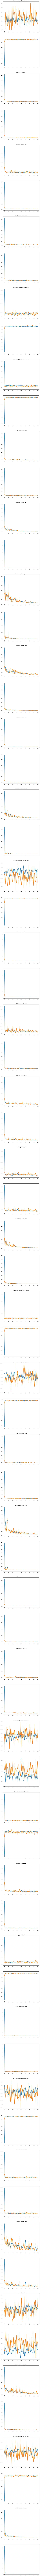

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(72,1, figsize=(10, 720))

index = 0
for key in historys:
    axes[index].plot(historys[key].history['loss'], label='train')
    axes[index].plot(historys[key].history['val_loss'], label='validate')
    axes[index].set_title(key)
    index += 1
    axes[index].plot(historys[key].history['mean_squared_error'], label='train')
    axes[index].plot(historys[key].history['val_mean_squared_error'], label='validate')
    index +=1
    
plt.show()

## 1.2 Training

这次固定损失函数，选择序列长度和隐藏单元数量
1. 隐藏单元数量还是没有固定的规律，随着隐藏数量的增加，损失值有的先降后升，也有的先升后降；总的来讲还是序列长度越大，需要的隐藏单元数量越多；
2. 使用早停法的思路不一定对，还是要寻找相关文献，重新做实验。

In [4]:
from math import ceil
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename

batch_size = 128
epochs = 500

lengths = [1, 16, 32, 48]
num_hiddens = [160, 240, 320, 480]
#num_hiddens = [40, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040]
#loss_functions = ['mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error']
historys = {}
errors = {}

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/"


for length in lengths:
    # reading data from csv
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # loading data through generator
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    training_steps = ceil(len(training_set)/batch_size)
    validation_steps = ceil(len(validation_set)/batch_size)
    
    for num_hidden in num_hiddens:
        print("==FOR THIS MODEL: length is: {}, num_hidden is: {}==".format(length,num_hidden))
        prefix = 'mlp'+'-'+str(length)+'-'+str(num_hidden)
        # define model
        model = Sequential()
        model.add(Dense(num_hidden, activation='relu', input_dim=length*16))
        model.add(Dense(1))
            
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
        model.summary()
        model_checkpoint = ModelCheckpoint(model_path+prefix+'-'+'best_model.h5', 
                                           monitor='val_mean_absolute_error',
                                           save_best_only=True)
        model_callbacks = [model_checkpoint]

        # fit model
        history = model.fit_generator(generator = train_generator,
                                      steps_per_epoch  = training_steps,
                                      validation_data  = valid_generator,
                                      validation_steps = validation_steps,
                                      epochs  = epochs,
                                      verbose = 0,
                                      callbacks = model_callbacks)
        # save training histroys
        hist_key = prefix + '-'+'mae'
            
        historys[hist_key] = history
        
        # load the saved model
        saved_model = load_model(model_path+prefix+'-'+'best_model.h5')
        
        # evalute model
        train_loss, train_mae = saved_model.evaluate_generator(train_generator, 
                                                               steps=training_steps,
                                                               verbose=0)
        val_loss, val_mae= saved_model.evaluate_generator(valid_generator, 
                                                          steps=validation_steps,
                                                          verbose=0)
        errors[prefix+'-'+'train'] = train_mae
        errors[prefix+'-'+'val'] = val_mae


        print('{}: Train: {}, validation: {}'.format(hist_key, train_mae, val_mae))
        print(" ")



Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6509 data after slicing with length 1
The training set size is 5207
The validation set size is 1302
==FOR THIS MODEL: length is: 1, num_hidden is: 160==
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 160)               2720      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________
mlp-1-160-mae: Train: 0.0285213334486, validation: 0.032983440347
 
==FOR THIS MODEL: length is: 1, num_hidden is: 240==
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (N

mlp-32-320-mae: Train: 0.0190567307873, validation: 0.0202250580303
 
==FOR THIS MODEL: length is: 32, num_hidden is: 480==
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 480)               246240    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 481       
Total params: 246,721
Trainable params: 246,721
Non-trainable params: 0
_________________________________________________________________
mlp-32-480-mae: Train: 0.0191022302723, validation: 0.0183122788556
 
Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6462 data after slicing with length 48
The training set size is 5169
The validation set size is 1293
==FOR THIS MODEL: length is: 48, num_hidden is: 160==
_________________________________________________________________
Layer (type)      

## 1.4 Predict

In [30]:
from keras.models import load_model
import numpy as np
import os
from random import choice
import datetime

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/best_model.h5"

model_mlp = load_model(model_path)

training_set, validation_set = loading_data_set(csv_path, length=1, split=0.2)
    # load data through generator    
train_generator = data_generator(training_set, batch_size=1)
    


Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6509 data after slicing with length 1
The training set size is 5207
The validation set size is 1302
Prdiction is done! Totally use 0 seconds, 164281 microseconds
prediction is : 0.0188288092613, the truth is [-0.]


In [109]:
x1,y1 = next(train_generator)

old_time = datetime.datetime.now()


test_array = x1

# desired input shape is (1,16)
prediction= model_mlp.predict(test_array, batch_size=1)
diff_time = datetime.datetime.now() - old_time
print("Prdiction is done! Totally use {} seconds, {} microseconds".format(diff_time.seconds, 
                                                                          diff_time.microseconds))
print("prediction is : {}, the truth is {}".format(prediction[0][0], y1))

Prdiction is done! Totally use 0 seconds, 816 microseconds
prediction is : 0.00739585608244, the truth is [0.25585192]


In [14]:
prediction[0][0]

0.0942827

In [5]:
errors

{'mlp-1-160-train': 0.02852133344858885,
 'mlp-1-160-val': 0.032983440347015856,
 'mlp-1-240-train': 0.027531072357669474,
 'mlp-1-240-val': 0.02914499454200268,
 'mlp-1-320-train': 0.025659578246995808,
 'mlp-1-320-val': 0.027425210736691952,
 'mlp-1-480-train': 0.025015171663835645,
 'mlp-1-480-val': 0.027108949981629847,
 'mlp-16-160-train': 0.019810288748703896,
 'mlp-16-160-val': 0.02073548473417759,
 'mlp-16-240-train': 0.021435303171165286,
 'mlp-16-240-val': 0.024112710636109112,
 'mlp-16-320-train': 0.019624551571905614,
 'mlp-16-320-val': 0.02109655225649476,
 'mlp-16-480-train': 0.019891444337554277,
 'mlp-16-480-val': 0.019962995126843453,
 'mlp-32-160-train': 0.020054439571686088,
 'mlp-32-160-val': 0.02020940463989973,
 'mlp-32-240-train': 0.018371124984696507,
 'mlp-32-240-val': 0.020353161636739968,
 'mlp-32-320-train': 0.01905673078726977,
 'mlp-32-320-val': 0.020225058030337095,
 'mlp-32-480-train': 0.019102230272255837,
 'mlp-32-480-val': 0.01831227885559201,
 'mlp-4

In [7]:
historys

{'mlp-1-160-mae': <keras.callbacks.History at 0x7f2cd55eaf90>,
 'mlp-1-240-mae': <keras.callbacks.History at 0x7f2d4f944650>,
 'mlp-1-320-mae': <keras.callbacks.History at 0x7f2cd48f2450>,
 'mlp-1-480-mae': <keras.callbacks.History at 0x7f2cd527fa50>,
 'mlp-16-160-mae': <keras.callbacks.History at 0x7f2cbf853810>,
 'mlp-16-240-mae': <keras.callbacks.History at 0x7f2cbd8712d0>,
 'mlp-16-320-mae': <keras.callbacks.History at 0x7f2c54044850>,
 'mlp-16-480-mae': <keras.callbacks.History at 0x7f2c139d3d90>,
 'mlp-32-160-mae': <keras.callbacks.History at 0x7f2cd51fcd10>,
 'mlp-32-240-mae': <keras.callbacks.History at 0x7f2c1127ac10>,
 'mlp-32-320-mae': <keras.callbacks.History at 0x7f2c107cc450>,
 'mlp-32-480-mae': <keras.callbacks.History at 0x7f2c0f268150>,
 'mlp-48-160-mae': <keras.callbacks.History at 0x7f2c0e88a950>,
 'mlp-48-240-mae': <keras.callbacks.History at 0x7f2c0e856350>,
 'mlp-48-320-mae': <keras.callbacks.History at 0x7f2c0b1b5050>,
 'mlp-48-480-mae': <keras.callbacks.History 

# 代办事项：
1. 使用早停法，重新训练并画出训练过程，并比较早停法参数设置是否合理（与500epoch训练结果想比较）
2. 可以单独与早期超声波导航的文章作对比，证明拟合比分类更有优势；工作量不够就加上数据集的工作